# Contradictory, My Dear Watson

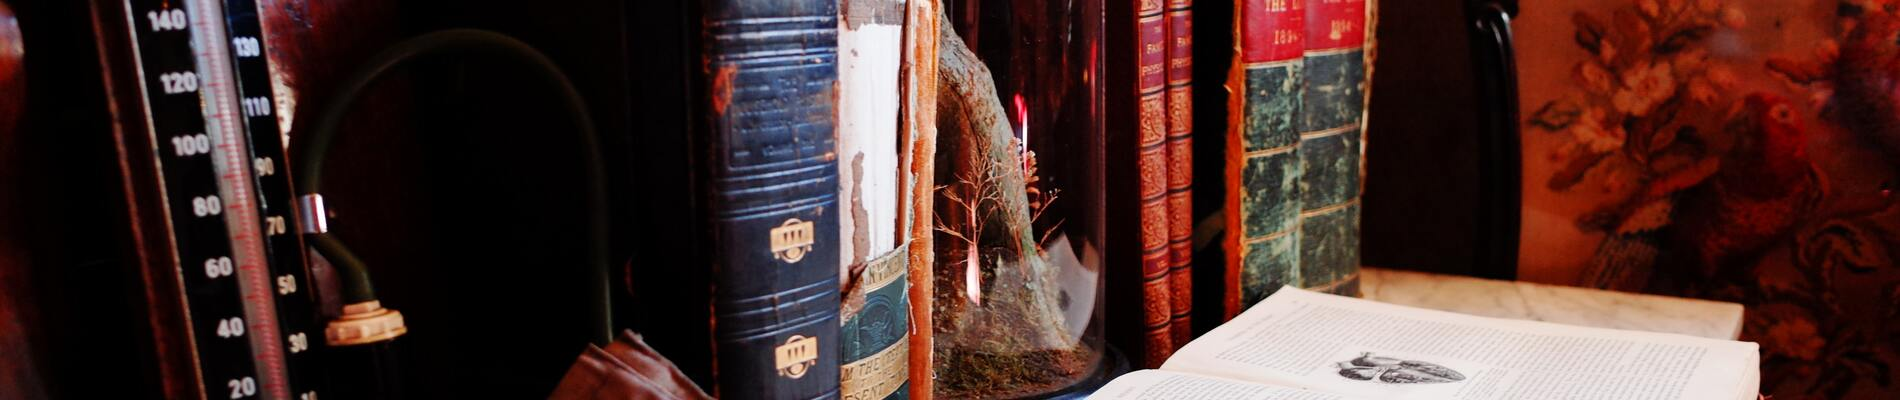

Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related. That is, the task is to assign labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses.

In this notebook we use pretrained model to solve NLI problem at the [Contradictory, My Dear Watson](https://www.kaggle.com/c/contradictory-my-dear-watson/data) dataset.

Special thanks to [Hugging Face](https://huggingface.co/) for the very useful libraries:


*   `transformers` - where we can take pretrained model for our problem
*   `nlp` - for comfortable work with our dataset



# XLM-RoBERTa-large-XNLI

## Dependencies

Check that we have a GPU and check its memory size

In [ ]:
!nvidia-smi

Install `transformers` from master

In [ ]:
!pip install git+https://github.com/huggingface/transformers

Install `nlp`

In [ ]:
!pip install -U nlp

In [ ]:
import pandas as pd
import numpy as np
import torch
import nlp

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model

We will use a model XLM-RoBERTa large for sequence classification with weights [joeddav/xlm-roberta-large-xnli](https://huggingface.co/joeddav/xlm-roberta-large-xnli). This model has been pretrained to solve the NLI problem, so it has a pretrained classification head and we can use it without fine tuning.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("joeddav/xlm-roberta-large-xnli")
model = AutoModelForSequenceClassification.from_pretrained("joeddav/xlm-roberta-large-xnli").to(device)

In [ ]:
model

## Data

Let's take a part of the train dataset to evaluate this model:

In [ ]:
train_dataset = nlp.load_dataset('csv', data_files={'train': '../input/contradictory-my-dear-watson/train.csv'}, split='train[:1024]')

In [ ]:
train_dataset.num_rows

Look at the first example in our dataset:

In [ ]:
train_dataset[0]

We have to predict the `label` by `premise` and `hypothesis`.

Tokenize our dataset and format it for `pytorch`:

In [ ]:
def convert_to_features(batch):
    input_pairs = list(zip(batch['premise'], batch['hypothesis']))
    encodings = tokenizer.batch_encode_plus(input_pairs, 
                                            add_special_tokens=True,
                                            padding=False)

    return encodings


train_dataset = train_dataset.map(convert_to_features, batched=True)
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

Now we have such data:

In [ ]:
train_dataset[0]

We will pad the inputs to the max length in each batch separately by using `tokenizer.pad` as `the collate_fn`.

In [ ]:
batch_size = 16

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=tokenizer.pad
)

In [ ]:
for i, batch in enumerate(train_dataloader):
    # print('Batch : {}'.format(batch))
    print('Input shape : {}'.format(batch['input_ids'].shape))
    print()
    if i == 4:
        break

As we can see, the max length of input sequences is determined separately for each batch,

`input_ids` is padded with `1`,
`attention_mask` is padded with `0`,
`label` remains unchanged:

In [ ]:
batch['input_ids']

In [ ]:
batch['attention_mask']

In [ ]:
batch['label']

## Evaluation

We use accuracy as a metric for the evaluation.

In [ ]:
def eval(model, dataloader, device):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            val_loss += loss.item()
            correct += (outputs[1].argmax(dim=-1) == labels).float().sum()

    return val_loss / len(dataloader),  correct / dataloader.dataset.shape[0]

In [ ]:
%%time
val_loss, val_acc = eval(model, train_dataloader, device)

In [ ]:
print(f'Loss : {val_loss:.5}, Accuracy : {val_acc:.2%}')

It doesn't look like a good result. The fact is that in the pretrained RoBERTa model the label indices are swapped.

Indeed, look at some predictions:

In [ ]:
model.eval()
with torch.no_grad():
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)[0]
    print(f'Output : {torch.argmax(outputs, -1).cpu().detach()}')
    print('Target : {}'.format(batch['label']))

Labels 0 and 2 are swapped.

## Data 2

Let's take the same part of the train dataset and swap the labels 0 and 2.

In [ ]:
train = pd.read_csv('../input/contradictory-my-dear-watson/train.csv', nrows=1024)

In [ ]:
train.head()

In [ ]:
train.label.replace([0, 2], [2, 0], inplace=True)

In [ ]:
train.head()

In [ ]:
train_dataset = nlp.Dataset.from_pandas(train)

In [ ]:
train_dataset.num_rows

In [ ]:
train_dataset[0]

In [ ]:
%%time
train_dataset = train_dataset.map(convert_to_features, batched=True)
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=tokenizer.pad
)

## Evaluation 2

Let's try to evaluate again:

In [ ]:
%%time
val_loss, val_acc = eval(model, train_dataloader, device)

In [ ]:
print(f'Loss : {val_loss:.5}, Accuracy : {val_acc:.2%}')

This is a great result!

## Submission

Now we can make and submit predictions for test dataset:

In [ ]:
sample_submission = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')

In [ ]:
test_dataset = nlp.load_dataset('csv', data_files={'test': '../input/contradictory-my-dear-watson/test.csv'})
test_dataset = test_dataset.map(convert_to_features, batched=True) 
test_dataset.set_format("torch", columns=['input_ids', 'attention_mask'])

In [ ]:
test_dataloader = DataLoader(
        test_dataset['test'], 
        batch_size=batch_size,
        drop_last=False,
        num_workers=0,
        shuffle=False,
        collate_fn=tokenizer.pad
    )

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    val_loss = 0
    correct = 0
    test_preds = np.array([])
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)[0]
            test_preds = np.concatenate((test_preds, torch.argmax(outputs, -1).cpu().detach().numpy()))

    sample_submission.prediction = test_preds.astype(int)
    sample_submission.prediction.replace([0, 2], [2, 0], inplace=True)
    sample_submission.to_csv('submission.csv', index=False)

    return sample_submission

In [ ]:
%%time
predict(model, test_dataloader, device)

Unfortunately, this is not a completely fair result, because the data for training the model `joeddav/xlm-roberta-large-xnli` probably contained test data from our dataset.

I hope you find this notebook interesting. Good luck!